# 2 - Human Mobility Measures

we can compute on a `TrajDataFrame` two types of measures:

- **individual measures**, describing features related to the mobility patterns of a single individual
- **collective measures**, describing the mobility patterns of an entire population of individuals

In [1]:
# let's import useful libraries

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from stats_utils import *
from tqdm import tqdm

In [2]:
# let's import the TrajDataFrame
import skmob
from skmob import TrajDataFrame

## Loading the data
- We load data of *checkins* made by users on **Brightkite**
- Brightkite is a location-based social network (LBSN)
- The dataset is freely available at the SNAP website: https://snap.stanford.edu/data/loc-brightkite.html

In [3]:
# we download the dataset into a pandas DataFrame
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=100000, 
                 names=['user', 'check-in_time', 
                        "latitude", "longitude", 
                        "location id"])

# We then convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
                          longitude='longitude', 
                          datetime='check-in_time',
                          user_id='user')
tdf.head()

,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [4]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 162
number of records:	 100000


# Individual measures

- quantify aspects of mobility regarding a single moving individual
- examples: length of displacements, charateristic distance, visitation frequency, etc.

## Jump lengths
- It indicates the distance an individual travels between two locations. 
- The function ``jump_lengths`` computes, for each individual in the input `TrajDataFrame`, their jump lengths.

In [ ]:
from skmob.measures.individual import jump_lengths

In [ ]:
jl_df = jump_lengths(tdf)
jl_df.head()

In [ ]:
jl_list = jump_lengths(tdf, merge=True)
len(jl_list)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x, y = zip(*lbpdf(1.5, jl_list[:10000]))
ax1.plot(x, y, marker='o')
ax1.set_xlabel('jump length [km]', fontsize=15)
ax1.set_ylabel('P(jump length)', fontsize=15)
ax1.loglog()
x, y = zip(*lbpdf(1.5, [d for d in jl_list if d >= 1.0]))
ax2.plot(x, y, marker='o')
ax2.set_xlabel('jump length [km] > 0', fontsize=15)
ax2.loglog()
plt.show()

### Computing distances
We can compute several kinds of distances:
- maximum distance
- distance straight line
- maximum distance from home

In [ ]:
from skmob.measures.individual import max_distance_from_home, distance_straight_line, maximum_distance

In [ ]:
md_df = maximum_distance(tdf)

In [ ]:
sld_df = distance_straight_line(tdf)

In [ ]:
mdh_df = max_distance_from_home(tdf)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(md_df.maximum_distance, bins=10, rwidth=0.8)
ax1.set_xlabel('max', fontsize=15)
x, y = zip(*lbpdf(2.0, list(sld_df.distance_straight_line)))
ax2.plot(x, y, marker='o')
ax2.loglog()
ax2.set_xlabel('straight', fontsize=15)
ax3.hist(mdh_df.max_distance_from_home, bins=10, rwidth=0.8)
ax3.set_xlabel('from home', fontsize=15)
ax2.set_title('Distances')
plt.show()

## Radius of gyration
The characteristic distance traveled by an individual in a given time period is *radius of gyration*, $r_g$, and it is defined as the root mean square distance of a set of points from a given axis:

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

where $\mathbf{r}_i$ are the coordinates of the $N$ individual points (or $N$ measurements of location) and $r_{cm}$ is the position vector of the *center of mass* of the set of points, 
$$ r_{cm} = \sum_{i=1}^N \frac{\mathbf{r}_i}{N}$$

In [ ]:
from skmob.measures.individual import radius_of_gyration

In [ ]:
rg_df = radius_of_gyration(tdf).sort_values(by='radius_of_gyration')
rg_df.head()

In [ ]:
rgs = list(rg_df.radius_of_gyration)

In [ ]:
fontsize = 15
fig, (ax1, ax2) = plt.subplots(1, 2)

x, y = zip(*lbpdf(1.5, rgs))
ax1.plot(x, y, marker='o')
ax1.set_xlabel('$r_g$ [km]', fontsize=20)
ax1.set_ylabel('P($r_g$)', fontsize=20)
ax1.loglog()
ax1.text(0.15, 0.15, '$r_g \geq 0$', transform=ax1.transAxes, fontsize=15)

x, y = zip(*lbpdf(1.5, [rg for rg in rgs if rg >= 1.0]))
ax2.plot(x, y, marker='o')
ax2.set_xlabel('$r_g$ [km]', fontsize=20)
ax2.set_ylabel('P($r_g$)', fontsize=20)
ax2.loglog()
ax2.text(0.15, 0.15, '$r_g \geq 1$', transform=ax2.transAxes, fontsize=15)

fig.subplots_adjust(wspace=0.5)

plt.show()

## $k$-radius of gyration
The $k$-radius of gyration $r_g^{(k)}$ quantifies the influence of frequency of location visits on the characteristic distance traveled, defined as the radius of gyration computed over an individual’s k most frequently visited locations $L_1, \dots, L_k$:
$$ r_g^{(k)} = \sqrt{\frac{1}{N_k} \sum_{i=1}^{k} n_i (\mathbf{r}_i - \mathbf{r}_{cm}^{(k)})} $$
where $N_k$ is the sum of the visits to the $k$ most frequented locations, $\mathbf{r}_{cm}^{(k)}$ is the center of mass computed on those locations and $n_i$ is the number of visits to the $i$-th most visited location.

In [ ]:
from skmob.measures.individual import k_radius_of_gyration

In [ ]:
krg_df = k_radius_of_gyration(tdf, k=3)
krg_df.head()

In [ ]:
rg_krg_df = pd.merge(rg_df, krg_df, on='uid')
rg_krg_df.head()

In [ ]:
fontsize = 15
fig = plt.figure(figsize=(6, 6))
plt.scatter(rg_krg_df.radius_of_gyration, rg_krg_df['3k_radius_of_gyration'], alpha=0.2)
plt.xlabel('radius of gyration [km]', fontsize=fontsize)
plt.ylabel('k-radius of gyration [km]', fontsize=fontsize)
plt.show()

## Entropy
The measures of entropy quantifies the degree of predictability of an individual's mobility.

In [ ]:
from skmob.measures.individual import random_entropy, uncorrelated_entropy, real_entropy, number_of_locations

### Random entropy
The random entropy $S_{rand}(u)$ (in base 2) of an individual $u$ captures the degree of predictability of $u$'s whereabouts if each location is visited with equal probability.

In [ ]:
e_df = random_entropy(tdf)
e_df.head()

In [ ]:
locs_df = number_of_locations(tdf)
locs_df.head()

In [ ]:
e_df = pd.merge(e_df, locs_df, on='uid')
e_df.head()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.hist(e_df.random_entropy, bins=10, rwidth=0.8, density=True)
ax1.set_xlabel('random entropy', fontsize=fontsize)
ax1.set_ylabel('P(random entropy)', fontsize=fontsize)

ax2.hist(e_df[e_df.number_of_locations > 1].random_entropy, bins=10, rwidth=0.8, density=True)
ax2.set_xlabel('random entropy', fontsize=fontsize)

plt.show()

### Temporal-uncorrelated entropy
The temporal-uncorrelated entropy $S_{unc}(u)$ (in base 2) of an individual $u$ is the historical probability that a location $j$ was visited by $u$ and characterizes the heterogeneity of $u$'s visitation patterns.

In [ ]:
ue_df = uncorrelated_entropy(tdf)
nue_df = uncorrelated_entropy(tdf, normalize=True)
ue_df.head()

In [ ]:
ue_df = pd.merge(ue_df, locs_df, on='uid')
nue_df = pd.merge(nue_df, locs_df, on='uid')
nue_df.head()

In [ ]:
fig, axes = plt.subplots(2, 2)

axes[0][0].hist(ue_df.uncorrelated_entropy, bins=20, rwidth=0.8, density=True)
axes[0][1].hist(nue_df.norm_uncorrelated_entropy, bins=20, rwidth=0.8, density=True)

axes[1][0].hist(ue_df[ue_df.number_of_locations > 1].uncorrelated_entropy, bins=20, rwidth=0.8, density=True)
axes[1][1].hist(nue_df[ue_df.number_of_locations > 1].norm_uncorrelated_entropy, bins=20, rwidth=0.8, density=True)

axes[1][0].set_xlabel('unc entropy', fontsize=fontsize)
axes[1][1].set_xlabel('norm unc entropy', fontsize=fontsize)

plt.show()

### Real entropy
The real entropy $S$ of an individual $u$ depends not only on the frequency of visitation, but also the order in which the nodes were visited and the time spent at each location, thus capturing the full spatiotemporal order present in $u$'s mobility patterns.

In [ ]:
re_df = real_entropy(tdf[tdf.uid < 100])
re_df.head()

In [ ]:
plt.hist(re_df.real_entropy)
plt.xlabel('real entropy', fontsize=fontsize)
plt.show()

### Number of locations and Number of visits

In [ ]:
from skmob.measures.individual import number_of_visits

In [ ]:
nv_df = number_of_visits(tdf)
nv_df.head()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(locs_df.number_of_locations, rwidth=0.8, bins=20)
ax1.set_xlabel('number of locations', fontsize=fontsize)

ax2.hist(nv_df.number_of_visits, rwidth=0.8, bins=20)
ax2.set_xlabel('number of visits', fontsize=fontsize)

plt.show()

### Home location
The home location of an individual is the location they visit most frequently during nighttime. 

In [ ]:
from skmob.measures.individual import home_location

In [ ]:
hl_df = home_location(tdf)
hl_df.head()

In [ ]:
import folium
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(tiles = 'openstreetmap', zoom_start=10, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(hl_df[['lat', 'lng']].values).add_to(m)

# Show map
m

## Visitation frequency of locations
One method of quantifying the importance of a location is the use of ranks; the most visited location (likely home or work) would have rank 1, a school or local shop may have rank 2 or 3, etc.

In [ ]:
from skmob.measures.individual import location_frequency

In [ ]:
lf_df = location_frequency(tdf)
lf_df.head()

In [ ]:
lf_df.reset_index(inplace=True)
lf_df.head()

In [ ]:
ranks = [[] for i in range(lf_df.groupby('uid').count().max().location_frequency)]
for i, group in lf_df.groupby('uid'):
    for j, (index, row) in enumerate(group.iterrows()):
        ranks[j].append(row.location_frequency)

In [ ]:
ranks = [np.mean(rr) for rr in ranks]

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(range(len(ranks)), ranks, marker='o')
plt.loglog()
plt.xlabel('location rank', fontsize=15)
plt.ylabel('location frequency', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

## Frequency and Recency rank of locations

In [ ]:
from skmob.measures.individual import frequency_rank, recency_rank

In [ ]:
frequency_rank(tdf).head()

In [ ]:
recency_rank(tdf).head()

## Waiting times
Associated with the displacement between two successive locations is a time interval, that provides an estimate of the stay of an individual in a location (waiting-times).

In [ ]:
from skmob.measures.individual import waiting_times

In [ ]:
wt_df = waiting_times(tdf)
wt_df.head()

In [ ]:
wl_list = waiting_times(tdf, merge=True)
len(wl_list)

In [ ]:
fontsize = 15
fig = plt.figure(figsize=(6, 6))
x, y = zip(*lbpdf(1.5, wl_list[:10000]))
plt.plot(x, y, marker='o')
plt.grid(alpha=0.5)
plt.xlabel('waiting times [s]', fontsize=15)
plt.ylabel('P(waiting times)', fontsize=15)
plt.loglog()
plt.show()

## Individual mobility network
Another method of distinguishing between locations is to construct each individual's mobility pattern as a network. Nodes represent locations visited and directed edges represent trips between the locations. 

In [ ]:
from skmob.measures.individual import individual_mobility_network

In [ ]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

In [ ]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.head()

# Collective measures

## Homes per location

In [5]:
from skmob.measures.collective import homes_per_location

In [6]:
hl_df = homes_per_location(tdf)
hl_df.head()

100%|██████████| 162/162 [00:00<00:00, 179.41it/s]


,lat,lng,n_homes
0,39.739154,-104.984703,15
1,37.584103,-122.366083,6
2,40.014986,-105.270546,5
3,37.580304,-122.343679,5
4,37.774929,-122.419415,4


In [7]:
import folium
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(tiles = 'openstreetmap', zoom_start=10, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(hl_df[['lat', 'lng']].values).add_to(m)

# Show map
m

## Uncorrelated location entropy

In [8]:
from skmob.measures.collective import uncorrelated_location_entropy

In [10]:
ule_df = uncorrelated_location_entropy(tdf, show_progress=False)
ule_df.head()

,lat,lng,uncorrelated_location_entropy
0,-70.683333,-44.316667,0.0
1,-45.032284,168.660278,0.0
2,-45.032002,168.659399,0.0
3,-45.030226,168.662710,0.0
4,-42.516667,172.816667,0.0


In [11]:
nule_df = uncorrelated_location_entropy(tdf, normalize=True)
nule_df.head()

100%|██████████| 18447/18447 [00:17<00:00, 1069.42it/s]


,lat,lng,norm_uncorrelated_location_entropy
0,-70.683333,-44.316667,0.0
1,-45.032284,168.660278,0.0
2,-45.032002,168.659399,0.0
3,-45.030226,168.662710,0.0
4,-42.516667,172.816667,0.0


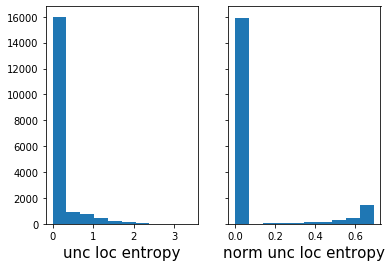

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(ule_df.uncorrelated_location_entropy)
ax1.set_xlabel('unc loc entropy', fontsize=15)

ax2.hist(nule_df.norm_uncorrelated_location_entropy)
ax2.set_xlabel('norm unc loc entropy', fontsize=15)

plt.show()

## Visits per location

In [13]:
from skmob.measures.collective import visits_per_location

In [14]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

,lat,lng,n_visits
0,39.739154,-104.984703,3392
1,37.580304,-122.343679,2248
2,39.099275,-76.848306,1715
3,39.762146,-104.982480,1442
4,40.014986,-105.270546,1310


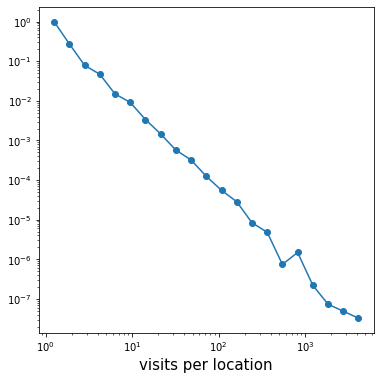

In [15]:
fig = plt.figure(figsize=(6, 6))
x, y = zip(*lbpdf(1.5, list(vpl_df.n_visits)))
plt.plot(x, y, marker='o')
plt.xlabel('visits per location', fontsize=15)
plt.loglog()
plt.show()

## Visits per time unit

In [16]:
from skmob.measures.collective import visits_per_time_unit

In [17]:
vtu_df = visits_per_time_unit(tdf)
vtu_df.head()

,n_visits
datetime,
2008-03-22 05:00:00+00:00,2
2008-03-22 06:00:00+00:00,2
2008-03-22 07:00:00+00:00,0
2008-03-22 08:00:00+00:00,0
2008-03-22 09:00:00+00:00,0


/home/lucpappalard/miniconda3/envs/skmob/lib/python3.7/site-packages/pandas-0.24.2-py3.7-linux-x86_64.egg/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


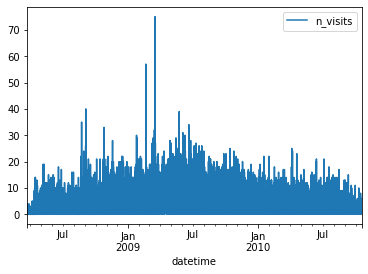

In [18]:
vtu_df.plot()

## Mean square displacement

In [19]:
from skmob.measures.collective import mean_square_displacement

In [20]:
mean_square_displacement(tdf)

100%|██████████| 162/162 [00:00<00:00, 444.42it/s]


6697977.363424443

## Origin destination matrix

In [21]:
from skmob.measures.collective import origin_destination_matrix

In [22]:
od_df = origin_destination_matrix(tdf)
od_df.head()

100%|██████████| 162/162 [00:00<00:00, 322.94it/s]


,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,37.774929,-122.419415,37.600747,-122.382376,2
1,37.774929,-122.419415,37.630490,-122.411084,8
2,37.774929,-122.419415,37.584103,-122.366083,50
3,37.774929,-122.419415,37.613825,-122.486919,2
4,37.774929,-122.419415,37.654656,-122.407750,3


In [23]:
data_set = [[1, 39.978253, 116.3272755, '2008-10-23 00:00:00', 0],
[1,40.013819, 116.306532,'2008-10-23 08:00:00', 1],
[1,39.878987, 116.1266865,'2008-10-23 12:00:00', 2],
[1,40.013819, 116.306532,'2008-10-23 14:00:00', 1],
[1,39.878987, 116.1266865,'2008-10-23 18:00:00', 2],
[1,40.2313819, 116.306532,'2008-10-23 19:00:00', 3],
[1, 39.978253, 116.3272755, '2008-10-24 00:00:00', 0], 
[1, 39.978253, 116.3272755, '2008-10-25 00:00:00', 0],
           [1, 39.978253, 116.3272755, '2008-10-25 00:00:00', 0]]

tdf = TrajDataFrame(data_set, latitude=1, longitude=2, datetime=3, user_id=0)
tdf.rename(columns={4: "location"}, inplace=True)

tdf

,uid,lat,lng,datetime,location
0,1,39.978253,116.327275,2008-10-23 00:00:00,0
1,1,40.013819,116.306532,2008-10-23 08:00:00,1
2,1,39.878987,116.126687,2008-10-23 12:00:00,2
3,1,40.013819,116.306532,2008-10-23 14:00:00,1
4,1,39.878987,116.126687,2008-10-23 18:00:00,2
5,1,40.231382,116.306532,2008-10-23 19:00:00,3
6,1,39.978253,116.327275,2008-10-24 00:00:00,0
7,1,39.978253,116.327275,2008-10-25 00:00:00,0
8,1,39.978253,116.327275,2008-10-25 00:00:00,0
